In [24]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import mannwhitneyu

Prepare data

In [25]:
df = pd.read_csv('data/DatasetEV3.csv')
df = df[(df['90%CCM, 91%IB, 97.5%IA_cyano']==1) & (df['Form']!='IAc_noncyano') & (df["100% representative"] == 1)]

df["Form"] = df["Form"].replace("IAc_cyano", "α-cyano")
df["Form"] = df["Form"].replace("IB", "β-cyano")
df["Form"] = df["Form"].replace("IAc_noncyano", "CCM-proteo")

my_pal = {"α-cyano":'#76e5d0ff', "β-cyano": '#55b9b1ff', "CCM-proteo":'#aacc68ff'}

Statistical tests

In [26]:
group1 = df[df['Form'] == 'α-cyano']["cell_volume_mean"].dropna()
group2 = df[df['Form'] == 'β-cyano']["cell_volume_mean"].dropna()

# Mann-Whitney U test
statistic, pvalue = mannwhitneyu(group1, group2)

if pvalue < 0.05:
    print(f'Mann-Whitney U test: The two groups are significantly different. p = {pvalue}')
else:
    print('Mann-Whitney U test: The two groups are not significantly different')  

Mann-Whitney U test: The two groups are significantly different. p = 1.0364681770446936e-05


Plot

/Users/bdepins/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:3543: UserWarning: 64.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


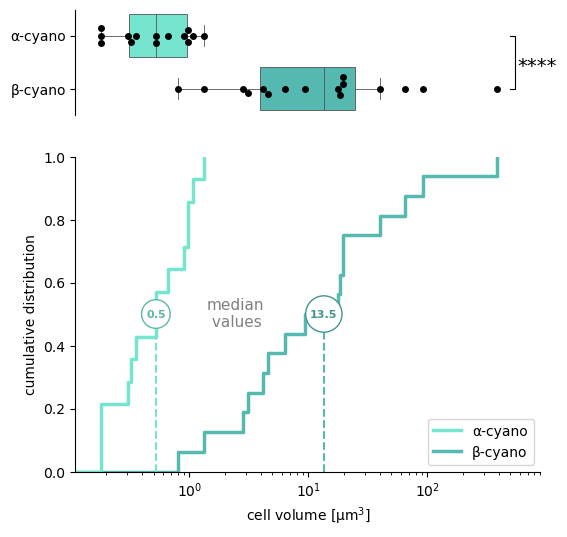

In [27]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 6), gridspec_kw={'height_ratios': [1, 3]})

# boxplot/swarmplot on first axis

sns.boxplot(data=df, x="cell_volume_mean", y='Form', palette=my_pal, ax=axs[0], saturation=1, order=["α-cyano", "β-cyano"], showfliers=False, linewidth=0.6)
sns.swarmplot(data=df, x="cell_volume_mean", y='Form', color='black', ax=axs[0], order=["α-cyano", "β-cyano"])

axs[0].set_xscale('log')
axs[0].set_ylabel('')
axs[0].spines.top.set_visible(False)
axs[0].spines.right.set_visible(False)
axs[0].spines.bottom.set_visible(False)
axs[0].set_xlabel('')
axs[0].set(xticklabels=[])
axs[0].tick_params(bottom=False)
axs[0].set_xlim(0.11, 900)
axs[0].minorticks_off()

# cdf on second axis

sns.ecdfplot(data=df, x="cell_volume_mean", hue='Form', palette=my_pal, ax=axs[1], linewidth=2.5)

axs[1].spines.top.set_visible(False)
axs[1].spines.right.set_visible(False)
axs[1].set_xlabel('cell volume [µm$^{3}$]')
axs[1].set_ylabel('cumulative distribution')
axs[1].legend_.set_title("")
sns.move_legend(axs[1], "lower right")
axs[1].set_xscale('log')
axs[1].set_xlim(0.11, 900)


# Add stars to box plot to indicate significance level
if pvalue <= 0.0001:
    star = '****'
elif pvalue <= 0.001:
    star = '***'
elif pvalue <= 0.01:
    star = '**'
elif pvalue <= 0.05:
    star = '*'
else:
    star = 'ns'
    
axs[0].plot([500.2, 550.4, 550.4, 500.2], [0, 0, 1, 1], lw=.8, c = 'black')
axs[0].text(850.5, .75, star, ha='center', va='bottom', fontsize=14)

axs[1].text(1.4, 0.46, 'median\n values', fontsize=11, color='grey')

# Find the x-coordinates of the points where the curves cross the y=0.5 line
xcoords = []
xcoords_original = []  # Store the original x-coordinates
for curve in axs[1].get_lines():
    xdata = curve.get_xdata()
    xcoord = np.median([x for x in xdata if x > 0])
    xcoords.append(xcoord)
    xcoords_original.append(xcoord)  # Store the original x-coordinate

# Find the minimum distance between any two markers on the x-axis
min_distance = float('inf')

for i in range(len(xcoords)):
    for j in range(i+1, len(xcoords)):
        distance = abs(xcoords[i] - xcoords[j])
        min_distance = min(min_distance, distance)

# Shift markers that are closer than 1 on the x-axis
for i in range(len(xcoords)):
    for j in range(i+1, len(xcoords)):
        distance = abs(xcoords[i] - xcoords[j])
        if distance < 1:
            if xcoords[i] < xcoords[j]:
                xcoords[i] -= 0.12
                xcoords[j] += 0.12
            else:
                xcoords[i] += 0.12
                xcoords[j] -= 0.12

# Draw vertical lines from the x-axis to the curve at the original x-coordinates
for curve, xcoord, xcoord_original in zip(axs[1].get_lines(), xcoords, xcoords_original):
    ycoord = 0.5
    curve_color = mcolors.to_rgb(curve.get_color())  # Convert color to RGB
    text_color = tuple(np.array(curve_color) * 0.8)  # Darken the color
    axs[1].vlines(xcoord_original, 0, ycoord, color=curve_color, linestyle='dashed')
    # Use the original x-coordinate for the label
    axs[1].annotate(f'{xcoord_original:.1f}', xy=(xcoord, ycoord), xytext=(xcoord, ycoord),
                    color=text_color,
                    ha='center', va='center', fontsize=8, fontweight='bold',
                    bbox=dict(facecolor='white', edgecolor=text_color, boxstyle='circle,pad=0.4'))


plt.savefig(r'plots/cell_size.png', dpi=300, bbox_inches='tight')
plt.show()

Summary table

In [28]:
grouped_df = df.groupby('Form')["cell_volume_mean"]

summary_table = grouped_df.agg(['count', 'median', 'std'])

iqr1 = grouped_df.quantile(0.25)
iqr3 = grouped_df.quantile(0.75)

summary_table = summary_table.round(4)
iqr1 = iqr1.round(4)
iqr3 = iqr3.round(4)

summary_table.columns = ['N', 'Median Cell Volume', 'Standard Deviation']
iqr1.name = 'IQR1'
iqr3.name = 'IQR3'

summary_table['IQR1'] = iqr1
summary_table['IQR3'] = iqr3

print(summary_table)

          N  Median Cell Volume  Standard Deviation    IQR1     IQR3
Form                                                                
α-cyano  14              0.5225              0.3834  0.3107   0.9552
β-cyano  16             13.5300             96.1006  3.9250  24.8250
